## Use Case 2: Image Caption Generation

### 1. Import Modules

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

### 2. Data Analysis

In [3]:
# Path for images and captions file
Flickr_images_dir = "Images"
captions_file = "captions.txt"

# Load and structure captions from captions.txt
captions = []
with open(captions_file, 'r') as f:
    # Skip the header row
    next(f)
    for line in f:
        parts = line.strip().split(',')
        
        # Check if line contains two parts (image_id and caption)
        if len(parts) == 2:
            image_id, caption = parts
            captions.append((image_id.split('.')[0], caption.lower()))  # Remove file extension from image_id

# Convert the list of tuples to a DataFrame
captions_df = pd.DataFrame(captions, columns=['filename', 'caption'])

# Check if the DataFrame loaded correctly
display("Loaded captions", captions_df.head())


'Loaded captions'

,filename,caption
0,1000268201_693b08cb0e,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e,a girl going into a wooden building .
2,1000268201_693b08cb0e,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e,a little girl in a pink dress going into a woo...


### 3. Extract Image Features

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
# extract features from image
features = {}
directory = os.path.join(Flickr_images_dir) 

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [8]:
# store features in pickle
pickle.dump(features, open(os.path.join(Flickr_images_dir, 'features.pkl'), 'wb')) #stored inside the images folder

In [4]:
# load features from pickle
with open(os.path.join(Flickr_images_dir, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

### 4. Split and Append the Captions Data with the Image

In [5]:
with open(os.path.join('captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [6]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [7]:
len(mapping)

8091

### 5. Preprocess Text Data

In [8]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption


### 6. Visualize the Text Before and After Cleaning

In [9]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [10]:
# preprocess the text
clean(mapping)

In [11]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### 7. Store the Preprocessed Captions into a List

In [12]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [13]:
len(all_captions)

40455

In [14]:
#Let us see the first ten captions
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

### 8. Tokenization_Vacobulary Size_Maximum Length of Captions

In [15]:
#Now we start processing the text data
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [16]:
vocab_size

8485

In [17]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

### 9. Train Test Split

In [18]:
#After preprocessing the data now we will train, test and split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [19]:
#Now we will define a batch and include the padding sequence

# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

### 10. Model Creation

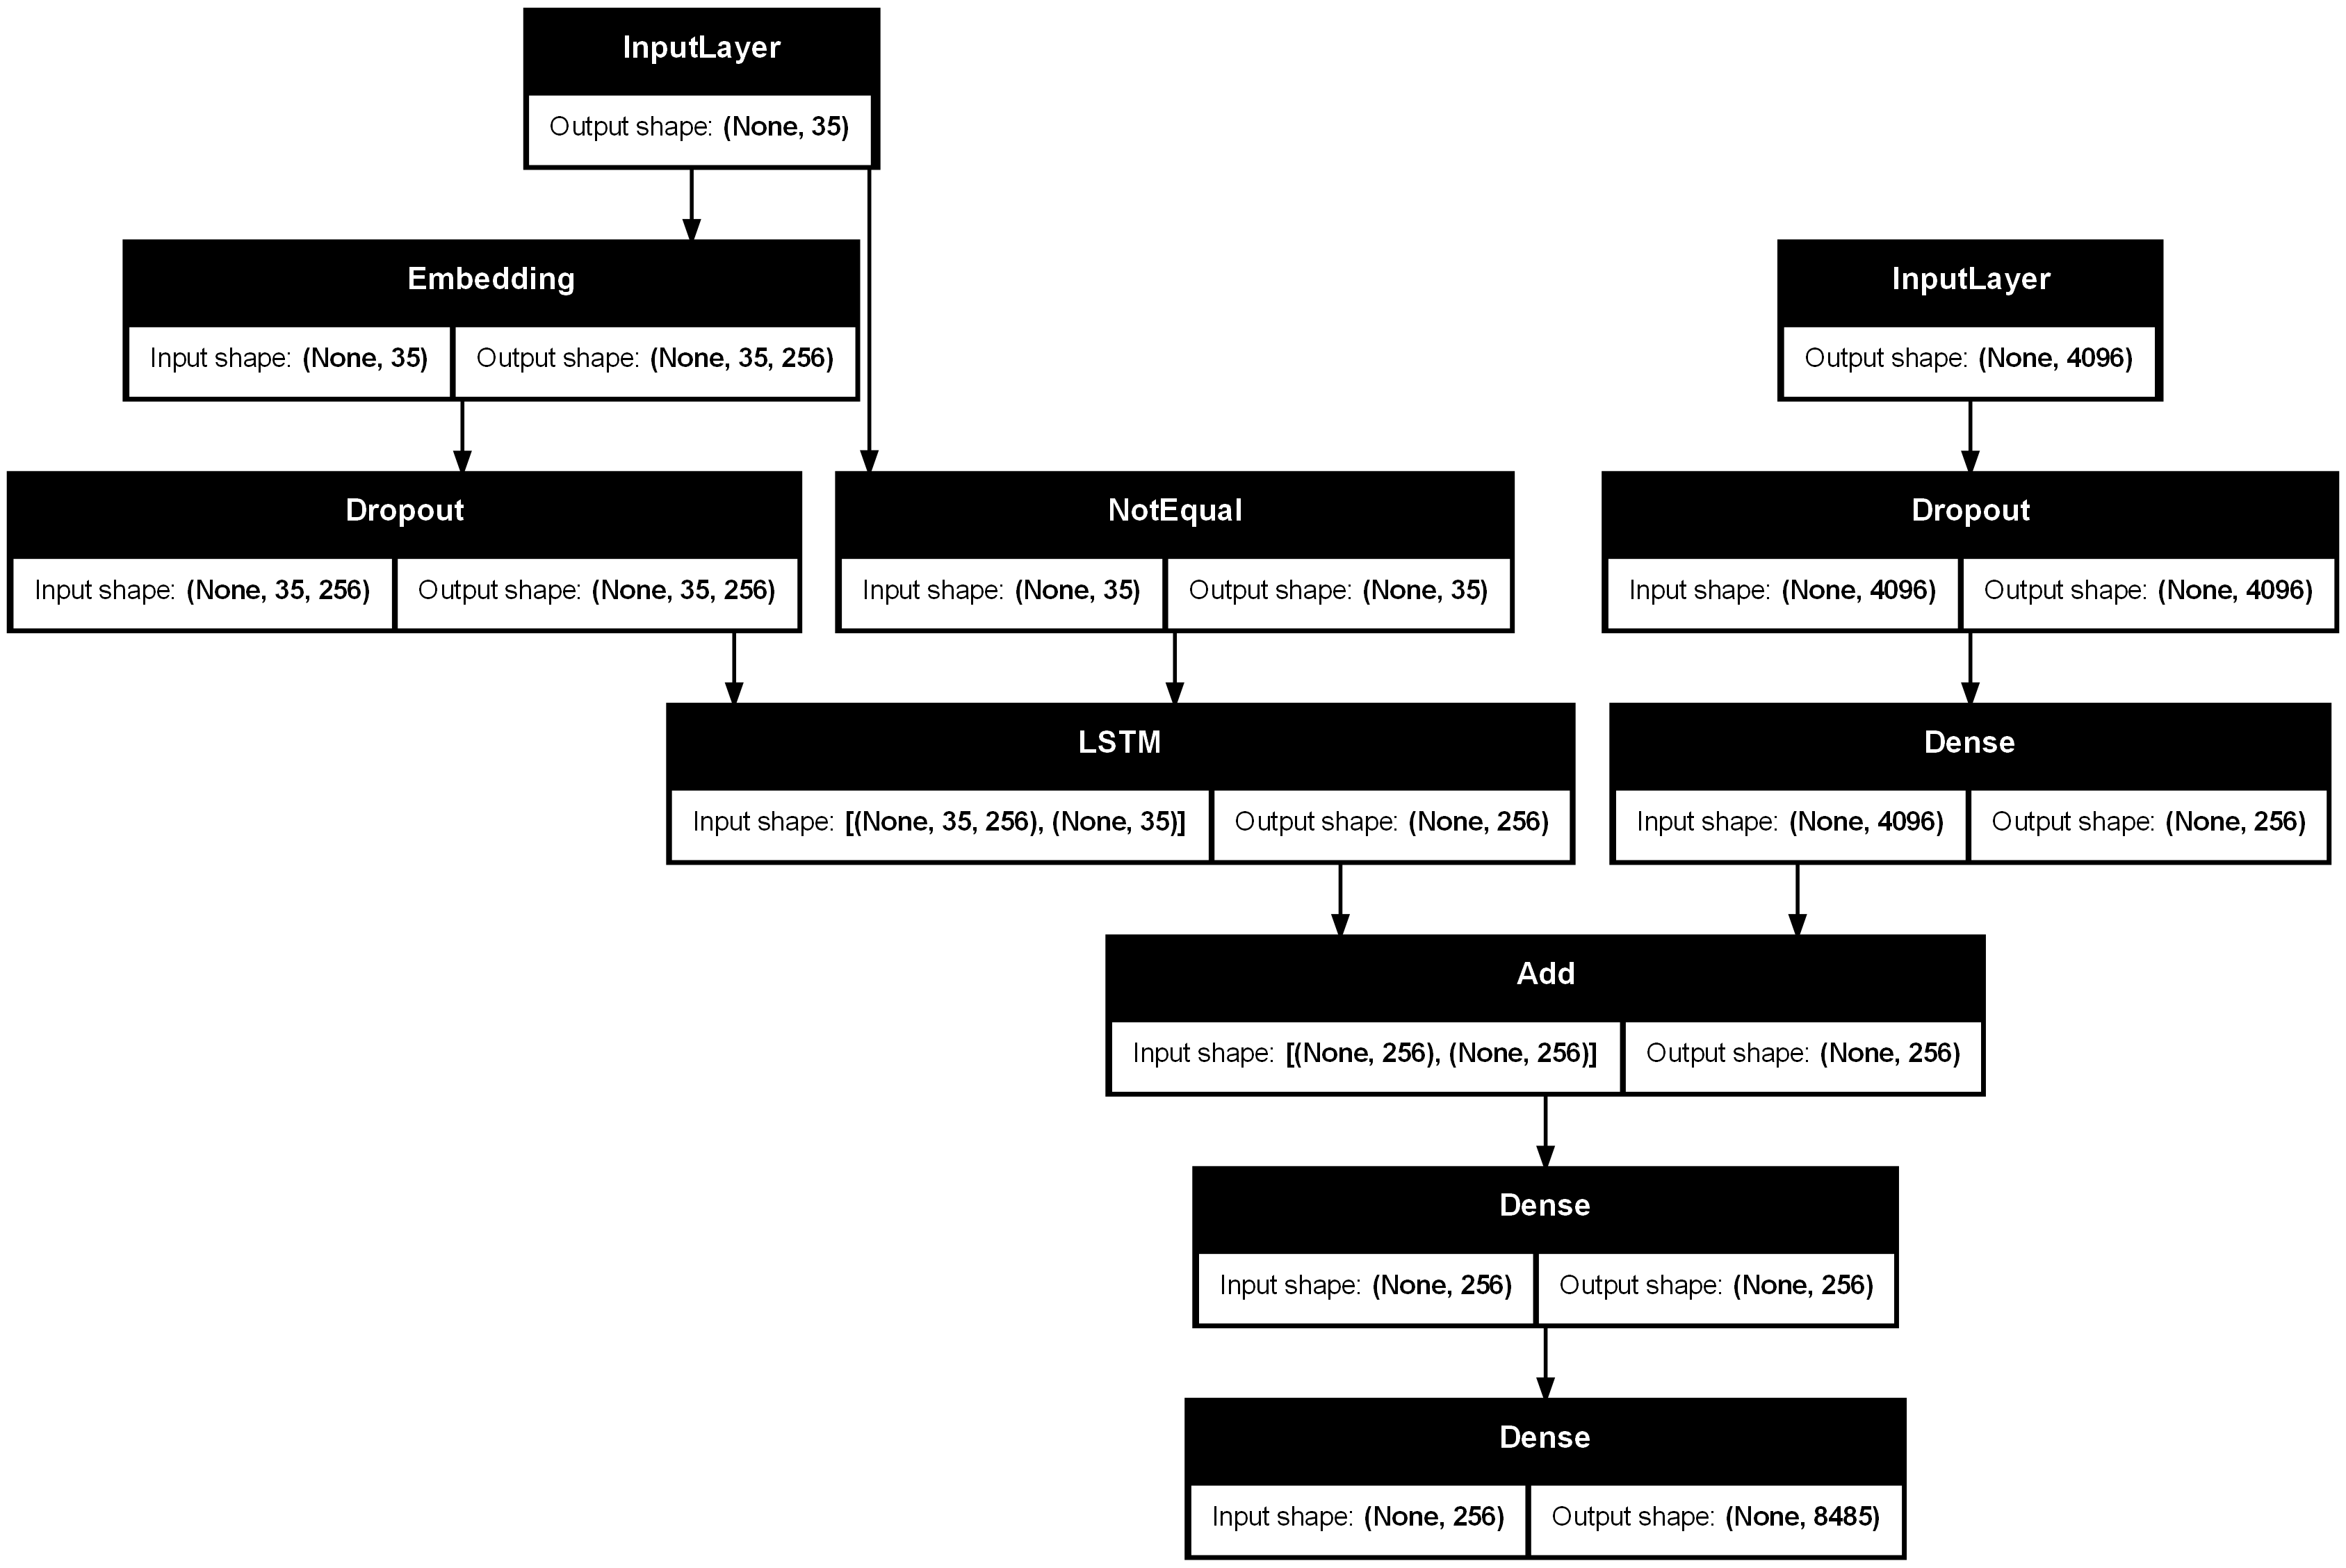

In [20]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [26]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


### 11. Model Training

In [21]:
#Now let us train the model
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 1500s 7s/step - loss: 5.7810
227/227 ━━━━━━━━━━━━━━━━━━━━ 1502s 7s/step - loss: 4.0685
227/227 ━━━━━━━━━━━━━━━━━━━━ 1506s 7s/step - loss: 3.5873
227/227 ━━━━━━━━━━━━━━━━━━━━ 1509s 7s/step - loss: 3.3007
227/227 ━━━━━━━━━━━━━━━━━━━━ 1513s 7s/step - loss: 3.0947
227/227 ━━━━━━━━━━━━━━━━━━━━ 1513s 7s/step - loss: 2.9446
227/227 ━━━━━━━━━━━━━━━━━━━━ 1513s 7s/step - loss: 2.8284
227/227 ━━━━━━━━━━━━━━━━━━━━ 1507s 7s/step - loss: 2.7353
227/227 ━━━━━━━━━━━━━━━━━━━━ 7712s 34s/step - loss: 2.6479
227/227 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - loss: 2.5791
227/227 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - loss: 2.5155
227/227 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - loss: 2.4616
227/227 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - loss: 2.4129
227/227 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - loss: 2.3674
227/227 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - loss: 2.3217
227/227 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - loss: 2.2819
227/227 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - loss: 2.2464
227/227 ━━━━━━━━━━━━━

### 12. Save the Model

In [22]:
# save the model
model.save(Flickr_images_dir+'/best_model.keras')

### 13. Load Model

In [20]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model(Flickr_images_dir + '/best_model.keras')

### 13.1 Training Model with Loss

227/227 ━━━━━━━━━━━━━━━━━━━━ 1478s 6s/step - loss: 2.1308
227/227 ━━━━━━━━━━━━━━━━━━━━ 1576s 7s/step - loss: 2.1029
227/227 ━━━━━━━━━━━━━━━━━━━━ 1317s 6s/step - loss: 2.0837
227/227 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - loss: 2.0601
227/227 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - loss: 2.0409
227/227 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - loss: 2.0226
227/227 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - loss: 2.0032
227/227 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - loss: 1.9846
227/227 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - loss: 1.9680
227/227 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - loss: 1.9511
227/227 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - loss: 1.9354
227/227 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - loss: 1.9204
227/227 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - loss: 1.9027
227/227 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - loss: 1.8861
227/227 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - loss: 1.8703
227/227 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - loss: 1.8559
227/227 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - loss: 1.8403
227/227 ━━━━━━━━━━━━━━━━━━━━

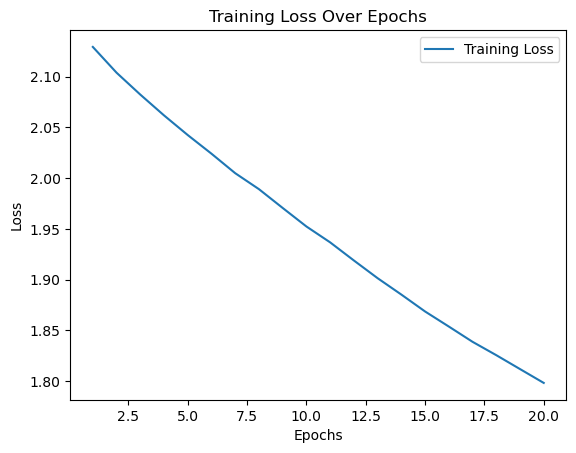

In [21]:
# Initialize lists to store loss values
train_loss = []

# Train the model for 20 epochs
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # Create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    # Fit for one epoch and capture the history
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    
    # Append the loss value for the epoch
    train_loss.append(history.history['loss'][0])

# Plot the training loss
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

### 14. Generate Captions for the Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

### 15. Convert the predicted index from the model into a word

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

### 16. Validate the data using BLEU Score

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.4444
BLEU-2: 0.2287
BLEU-1: 0.4333
BLEU-2: 0.2782
BLEU-1: 0.4884
BLEU-2: 0.3125
BLEU-1: 0.4643
BLEU-2: 0.2673
BLEU-1: 0.4559
BLEU-2: 0.2552
BLEU-1: 0.4684
BLEU-2: 0.2775
BLEU-1: 0.5000
BLEU-2: 0.3143
BLEU-1: 0.5158
BLEU-2: 0.3267
BLEU-1: 0.5000
BLEU-2: 0.3046
BLEU-1: 0.5000
BLEU-2: 0.2994
BLEU-1: 0.5081
BLEU-2: 0.2923
BLEU-1: 0.5076
BLEU-2: 0.2835
BLEU-1: 0.5252
BLEU-2: 0.2959
BLEU-1: 0.5000
BLEU-2: 0.2719
BLEU-1: 0.4939
BLEU-2: 0.2700
BLEU-1: 0.4885
BLEU-2: 0.2724
BLEU-1: 0.4946
BLEU-2: 0.2721
BLEU-1: 0.5000
BLEU-2: 0.2854
BLEU-1: 0.4976
BLEU-2: 0.2833
BLEU-1: 0.5000
BLEU-2: 0.2752
BLEU-1: 0.5043
BLEU-2: 0.2722
BLEU-1: 0.5020
BLEU-2: 0.2767
BLEU-1: 0.5156
BLEU-2: 0.2900
BLEU-1: 0.5227
BLEU-2: 0.2988
BLEU-1: 0.5351
BLEU-2: 0.3163
BLEU-1: 0.5412
BLEU-2: 0.3270
BLEU-1: 0.5366
BLEU-2: 0.3212
BLEU-1: 0.5199
BLEU-2: 0.3111
BLEU-1: 0.5208
BLEU-2: 0.3058
BLEU-1: 0.5347
BLEU-2: 0.3319
BLEU-1: 0.5353
BLEU-2: 0.3277
BLEU-1: 0.5429
BLEU-2: 0.3357
BLEU-1: 0.5385
BLEU-2: 0.3277
BLEU-1: 0.

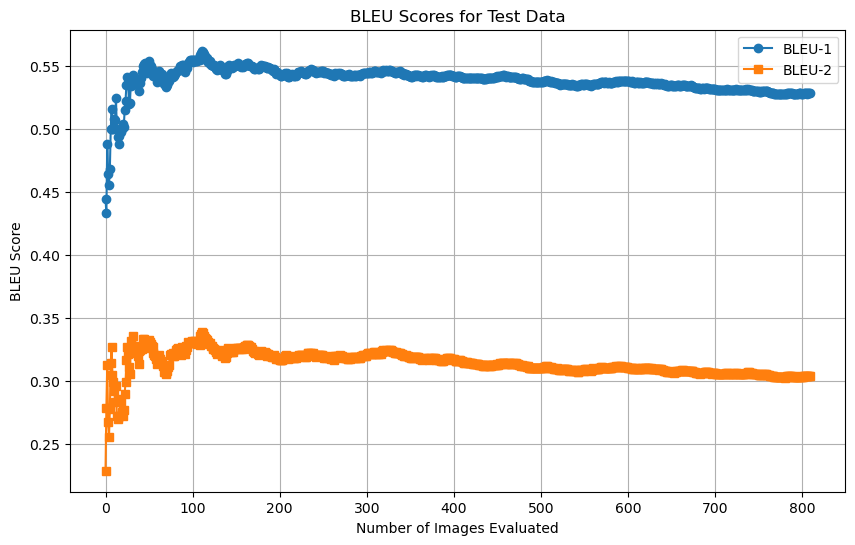

In [27]:
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Initialize lists to store BLEU scores
bleu1_scores = []
bleu2_scores = []

# Validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # Get actual captions
    captions = mapping[key]
    # Predict the caption for the image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # Split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # Append to the lists
    actual.append(actual_captions)
    predicted.append(y_pred)
    # Calculate BLEU scores
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu1_scores.append(bleu1)
    bleu2_scores.append(bleu2)
    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-2: {bleu2:.4f}")

# Plot BLEU scores
plt.figure(figsize=(10, 6))
plt.plot(bleu1_scores, label="BLEU-1", marker="o")
plt.plot(bleu2_scores, label="BLEU-2", marker="s")
plt.xlabel("Number of Images Evaluated")
plt.ylabel("BLEU Score")
plt.title("BLEU Scores for Test Data")
plt.legend()
plt.grid(True)
plt.show()

### 17. Visualize the Results

In [27]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(Flickr_images_dir, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq four wheel drive car is navigating along rocky off road trail endseq
startseq jeep sidewalks on some rocks endseq
startseq red jeep hangs from the edge of rocky cliff as girl looks on endseq
startseq red truck is driving over rocky surface endseq
startseq woman stands next to red suv that has run off into ditch endseq
--------------------Predicted--------------------
startseq red truck crosses rocky rocky rocky road endseq


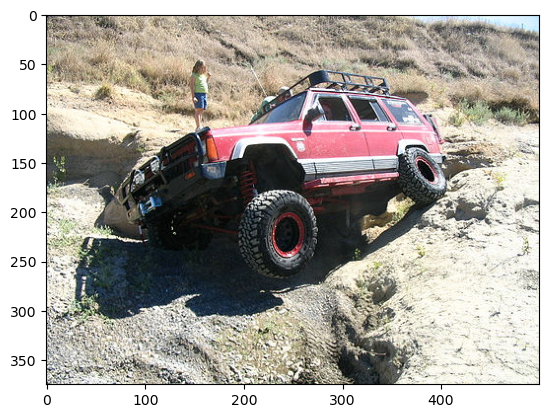

In [28]:
generate_caption("36422830_55c844bc2d.jpg")

### 18. Test with Real Image

In [29]:
vgg_model = VGG16() 
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs,             
                  outputs=vgg_model.layers[-2].output)

In [30]:
image_path = "C:/Users/Lenovo/Desktop/Image Description Generation/Images/47870024_73a4481f7d.jpg"
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq man in red sox shirt is pointing trick on his skateboard endseq'

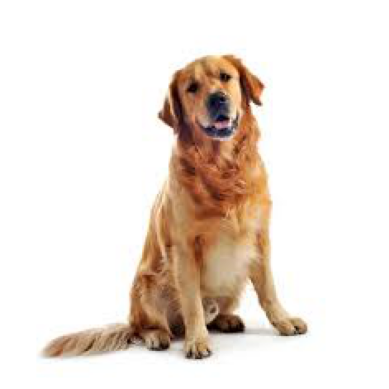

Generated Caption: startseq dog with collar sits on the grass endseq


In [31]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import numpy as np

# Load and preprocess the image
image_path = "C:/Users/Lenovo/Desktop/Image Description Generation/testimages/browndog.jpeg"
image = load_img(image_path, target_size=(224, 224))  # Load the image with target size

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()

# Convert image pixels to a numpy array
image_array = img_to_array(image)

# Reshape data for the model
image_array = image_array.reshape((1, image_array.shape[0], image_array.shape[1], image_array.shape[2]))

# Preprocess image for VGG
image_array = preprocess_input(image_array)

# Extract features
feature = vgg_model.predict(image_array, verbose=0)

# Generate the caption using the trained model
caption = predict_caption(model, feature, tokenizer, max_length)

# Display the generated caption
print("Generated Caption:", caption)
